In [1]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/notebook03'

# 01 - Begin Analysis

Enter the path to the dictionary generated by Notebook 01

In [2]:
dict_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/notebook01/tmp/dataset_dict.json'

What correlation method would you like to use?
- Pearson is very fast, but depends on linearity and is sensitive to outliers
- Spearman is slower, but much more robust

In [3]:
correlation = 'spearman'

In [4]:
from calvin_utils.ccm_utils.npy_utils import DataLoader
from calvin_utils.ccm_utils.stat_utils import CorrelationCalculator
data_loader = DataLoader(dict_path)
correlation_calculator = CorrelationCalculator(method=correlation, verbose=False)
corr_map_dict = correlation_calculator.generate_correlation_maps(data_loader)

Evaluating AD Fornix DBS
Evaluating PD STN DBS


Identify Datasets that Belong to Different Categories. 

Groups (values) allocate datasets to a fixed effect analysis. If no groups, set group_dict = {}
```
{
'dataset_1': 'group1',
'dataset_2': 'group2',
'dataset_3': 'group1'
}
```

In [5]:
corr_map_dict.keys()

dict_keys(['AD Fornix DBS', 'PD STN DBS'])

Print out datasets

In [6]:
group_dict = {}
    # 'ANT DBS SANTE' : 'DBS',
    # 'STN DBS' : 'DBS',
    # 'ANT DBS Maastricht' : 'DBS',
    # 'Epilepsy iEEG' : 'DBS',
    # 'Alzheimer Disease' : 'Lesion',
    # 'Acute Stroke' : 'Lesion',
    # 'Multiple Sclerosis' : 'Lesion',
    # 'Penetrating TBI' : 'Lesion',
    # 'Parietal TMS Wang' : 'TMS',
    # 'Parietal TMS Hermiller 2019a' : 'TMS',
    # 'Parietal TMS Hermiller 2019b' : 'TMS',
    # 'Parietal TMS Hebscher' : 'TMS'
    # }

# 02 - Use LOOCV to Train a Convergent Map on N-1 Datasets, Then Test it on the Nth dataset

Enter a list of datasets you want to flip (multiply correlation map by -1)
- This is typically done to control for sign inversion, enabling testing of topology specifically. 

In [7]:
datasets_to_flip = [] #'fornix_memory', 'adni_Alzheimer', 'corbetta_memory', 'grafmann_memory', 'manitoba_memory', 'ms_memory', 'kim_tms', 'hebscher_tms']

Generate the Convergent Maps and Save the Individual Correlation Maps

In [8]:
from calvin_utils.ccm_utils.ccm_utils import LOOCVAnalyzer
loocv_analyzer = LOOCVAnalyzer(corr_map_dict, data_loader, 
                               similarity='spatial_correl',
                               optimizer=False,
                               method=correlation, n_bootstrap=1000, 
                               out_dir=out_dir,
                               weight=True,
                               mask_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/atlases/MNI_structures/cortex/combined_cortex_cerebellum_mask_resampled.nii',
                               roi_path=None,
                               datasets_to_flip=datasets_to_flip,
                               align_all_maps=True
                               )

Removing NaNS from self.coor_map_dict.


Generate Agreement Maps

In [9]:
# loocv_analyzer.generate_and_save_maps(group_dict=group_dict, dir='convergence_maps/', verbose=False)

Generate Group Level Maps

In [10]:
loocv_analyzer.save_individual_r_maps(dir='group_maps/', verbose=True)

(1, 155745) (902629,) (902629,)
(1, 155745) (902629,) (902629,)


Run LOOCV

In [11]:
# loocv_analyzer.run()
# display(loocv_analyzer.results_df)

# 03 - Compute Fixed Effects

Run It

In [12]:
# import pandas as pd
# df = loocv_analyzer.compute_fixed_effects_by_group(group_dict)
# meta_df = pd.concat([loocv_analyzer.results_df, df], ignore_index=True)
# meta_df

# 04 - Visualize Your Meta Analysis as a Forest Plot Figure 
- This is a meta-analysis. It presents the effect size (R/rho values) of your convergent map on the left-out map. 

Generate a Forest Plot of the Results

In [13]:
# from calvin_utils.ccm_utils.stat_utils import MetaConvergenceForestPlot
# meta_forest_plot = MetaConvergenceForestPlot(meta_df, sig_digits=2, out_dir=out_dir, table=True)
# meta_forest_plot.run()

# 05 - Compare How 2 Different Maps Relate to Your Outcome
- Enter paths to ROIs you want to test. Will see if one better predicts outcomes than the other

In [14]:
cvgt = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_07/best_maps/explains_most_variance/train_prune_test_performs_highly.nii.gz'
wted = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_07/best_maps/weighted_average/all_datasets_weighted_avg_r_map.nii.gz'

In [15]:
roi_path1=cvgt
roi_path2_list = ['/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_01/mikes_retarded_analysis/dataset_dict_dbs_noqsld/convergence_maps/all_datasets_weighted_avg_r_map.nii.gz']
method_list = ['bootstrap']

In [16]:
import os
import sys

for method in method_list:
    output_file_path = os.path.join(out_dir, f"{method}_pvals.txt")
    with open(output_file_path, 'w') as file:
        # Redirect stdout to the file
        original_stdout = sys.stdout
        sys.stdout = file
        try:
            for roi_path2 in roi_path2_list:
                print(f"\n\nEVALUATING: {os.path.basename(roi_path1)} vs {os.path.basename(roi_path2)}")
                loocv_analyzer.compare_roi_correlations(roi1=roi_path1, roi2=roi_path2, method=method, n_iter=1000, seed=42,delta_r2=True)
        finally:
            # Restore original stdout
            sys.stdout = original_stdout

FileNotFoundError: No such file or no access: '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_01/mikes_retarded_analysis/dataset_dict_dbs_noqsld/convergence_maps/all_datasets_weighted_avg_r_map.nii.gz'

Visualize the Differences

The differences are typically stored in:
- roi1 : BootstrapVisualizer.r_values['roi1]
- roi2 : BootstrapVisualizer.r_values['roi2]

Confidence Interval Method: Empiric Percentile


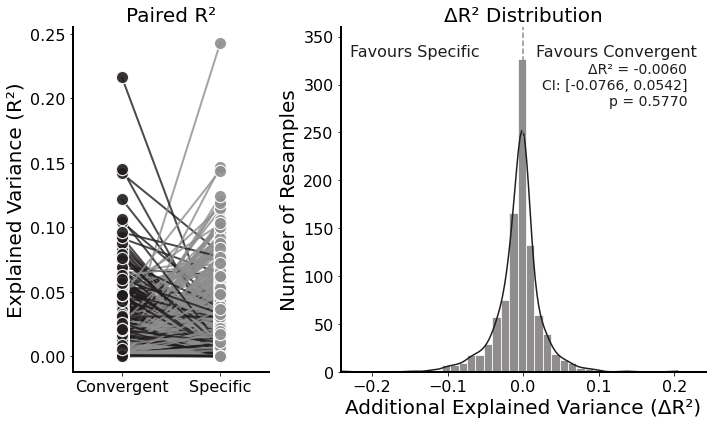

In [ ]:
import numpy as np
from calvin_utils.ccm_utils.resampling_plot import ResampleVisualizer
visualizer = ResampleVisualizer(
    stat_array_1=loocv_analyzer.r_values['roi1'],
    stat_array_2=loocv_analyzer.r_values['roi2'],
    model1_name="Convergent",
    model2_name="Specific",
    out_dir=out_dir+"/herm"
)
visualizer.draw()

That's all

-Calvin